In [6]:
from fastai.vision.all import *

In [2]:
# !cp /content/drive/MyDrive/model_seg_1.pkl /content/
# !cp /content/drive/MyDrive/data/wardrobe_helper_data/models/attr_3_weighted_unfreeze.pkl /content/

In [87]:
def _my_getter(path) : 
  return get_image_files(path/'train'/'image') + get_image_files(path/'valid'/'image')
def _my_y_getter(o) : 
  return Path((os.path.sep).join(str(o).split(os.sep)[:-2]))/'masks'/f'{o.stem}_m.png'

wp = 286.1918628411444
loss_fn = BCEWithLogitsLossFlat(reduction = 'none')
def my_loss(ypred, ytrue) :
        #print(ypred, ytrue)
        loss = loss_fn(ypred, ytrue)
        loss[ytrue.ravel() == 1] *= wp
        return loss.mean() * (1 + 1 / wp) / 2 

seg_learner = load_learner('model_seg_1.pkl')#, cpu = False) 
attribute_learner = load_learner('attr_3_weighted_unfreeze.pkl')#, cpu = False) 

In [19]:
# for base, fol, imgs in os.walk('/content/drive/MyDrive/data/wardrobe_helper_data/recommender/data') : 
imgs = get_image_files('/content/drive/MyDrive/data/wardrobe_helper_data/recommender/data')

In [ ]:
import matplotlib.pyplot as plt

In [104]:
back = image2tensor(to_image(plt.imread('back.jpg')).resize((224, 224)))
X = []
for img in imgs :
  img, msk, *_ = seg_learner.predict(img, with_input = True)
  img1 = img * (msk == 1) + TensorImage(back) * (msk != 1) 
  img2 = img * (msk == 2) + TensorImage(back) * (msk != 2) 
  # img1.show()
  # img2.show()
  atr1 = torch.sigmoid(attribute_learner.predict(img1)[1])
  atr2 = torch.sigmoid(attribute_learner.predict(img2)[1])
  X.append([np.array(atr1), np.array(atr2)]) 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [114]:
Kx = np.array(X).reshape((-1, 1000))

In [115]:
from sklearn.cluster import KMeans

In [116]:
kmeans_model = KMeans(10).fit(Kx)

In [122]:
# kmeans_model.predict(X[0][0].reshape(1, -1))

array([8], dtype=int32)

In [134]:
memory_matrix = np.zeros((10, 10))

for pair in X :
  cloth1 = kmeans_model.predict(pair[0].reshape(1, -1))
  cloth2 = kmeans_model.predict(pair[1].reshape(1, -1))
  memory_matrix[cloth1, cloth2] += 1
  memory_matrix[cloth2, cloth1] += 1

In [160]:
# memory_matrix

In [167]:
y_rank_matrix = np.argsort(np.argsort(memory_matrix, axis = 0), axis = 0)
x_rank_matrix = np.argsort(np.argsort(memory_matrix, axis = 1), axis = 1)

In [168]:
pants = get_image_files('/content/drive/MyDrive/data/wardrobe_helper_data/recommender/test_data/pant')
shirts = get_image_files('/content/drive/MyDrive/data/wardrobe_helper_data/recommender/test_data/shirt')

In [169]:
def recommender(shirt, pant) :
  img, msk, *_ = seg_learner.predict(shirt, with_input = True)
  img.show()
  img1 = img * (msk == 1) + TensorImage(back) * (msk != 1) 
  atr1 = torch.sigmoid(attribute_learner.predict(img1)[1])

  img, msk, *_ = seg_learner.predict(pant, with_input = True)
  img.show()

  img2 = img * (msk == 1) + TensorImage(back) * (msk != 1) 
  atr2 = torch.sigmoid(attribute_learner.predict(img2)[1])

  cloth1 = kmeans_model.predict(atr1.reshape(1, -1).numpy())
  cloth2 = kmeans_model.predict(atr2.reshape(1, -1).numpy())
  print(cloth1, cloth2)
  x_rank = x_rank_matrix[cloth1, cloth2]
  y_rank = y_rank_matrix[cloth1, cloth2]

  print('final match score :', x_rank * y_rank / 81)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[8] [1]
final match score : [0.88888889]


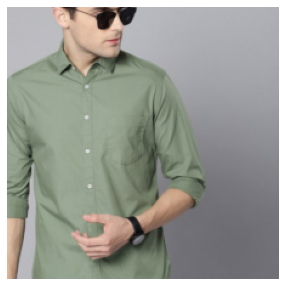

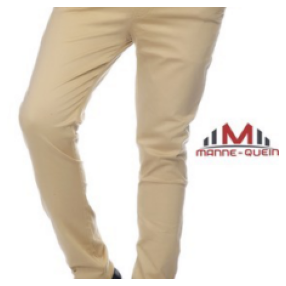

In [170]:
recommender(shirts[1], pants[2])